# Dec 24, 2021 (ROI layers: compare)

**Motivation**: Compare

- **Old approach**: chuncks with equal thickness, with
- **New approach**: depth 1 = layers 1 + 2/3 + 4; depth 2 = layer 5; depth 3 = layers 6a + 6b <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice((64, 0, 100), load_parcel=True, full_load=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Plot dorsal flatmap and topview

In [3]:
# HIDE CODE


from register.atlas import Allen

# cortical map parcel flatt & top
al10 = Allen(10, full_load=False)
template = al10.mcc.get_template_volume()[0]

top = al10.cortical_map(template, proj='top_view', agg_func=np.max)
flatmap = al10.cortical_map(template, proj='dorsal_flatmap', agg_func=np.max)

# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

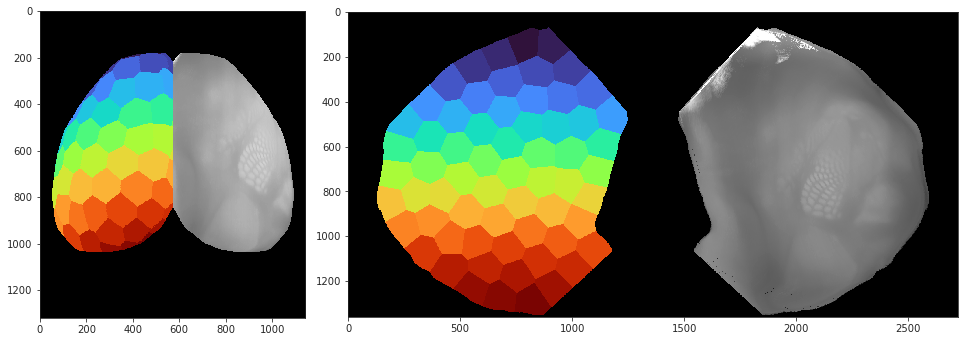

In [4]:
fig, axes = create_figure(1, 2, (13.5, 7), gridspec_kw={'width_ratios': [1, 2.3]})
axes[0].imshow(top, cmap='Greys_r')
x2plt = np.ma.masked_where(~np.isin(parcel_top, range(1, mice.cfg.nn + 1)), parcel_top)
axes[0].imshow(x2plt, cmap='turbo')

axes[1].imshow(flatmap, cmap='Greys_r')
x2plt = np.ma.masked_where(~np.isin(parcel_flat, range(1, mice.cfg.nn + 1)), parcel_flat)
axes[1].imshow(x2plt, cmap='turbo')
plt.show()

## Comparison (figs at $100 \mu m$ resolution)

In [5]:
# HIDE CODE


layer_mask_coarse, layer_mask = mice.al.make_layer_mask()

layer_mask_3 = sum(
    e.astype('int32') * i for i, e in
    enumerate(layer_mask_coarse.values(), start=1)
)

mice4 = Mice((192, 4, 100), load_parcel=True)

regions4 = mice4.parcel['cortex'][mice4.parcel['cortex'].nonzero()]
regions4 = np.unique(regions4)

hcl = mice4.parcel.decode(regions4)

layer_mask_4 = {
    f'layer-{ll}': np.isin(mice4.parcel['cortex'], mice4.parcel.encode(hcl[hcl[:, -1] == ll]))
    for ll in range(mice4.cfg.ll)
}
layer_mask_4 = sum(
    e.astype('int32') * i for i, e in
    enumerate(layer_mask_4.values(), start=1)
)

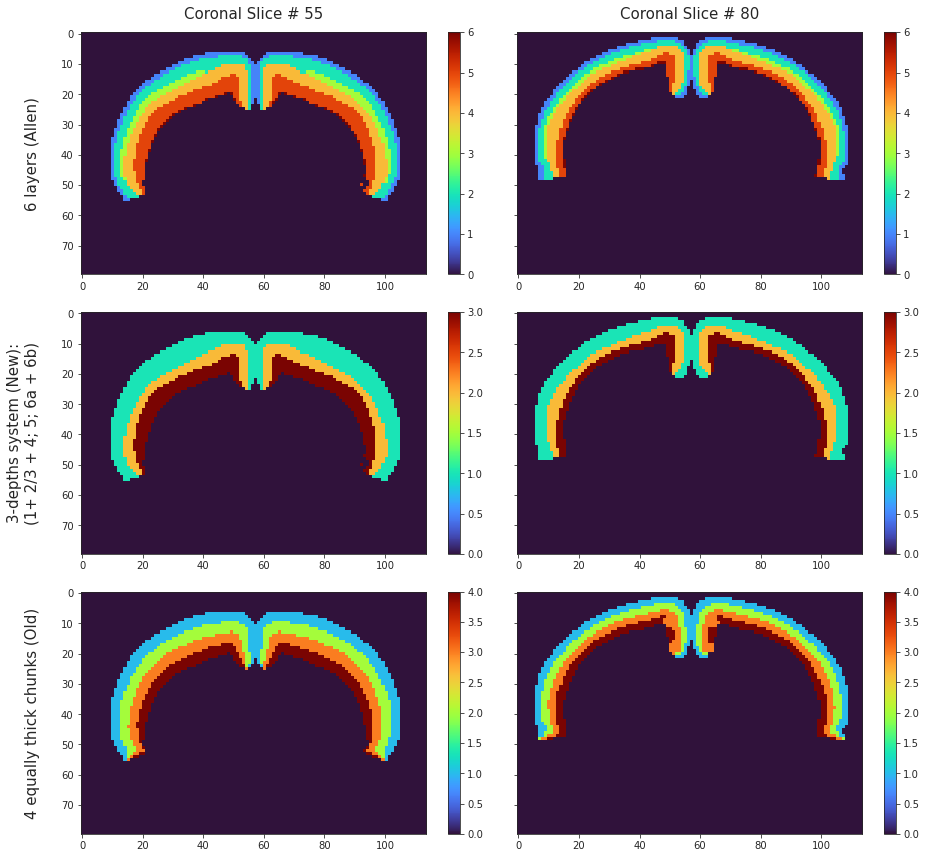

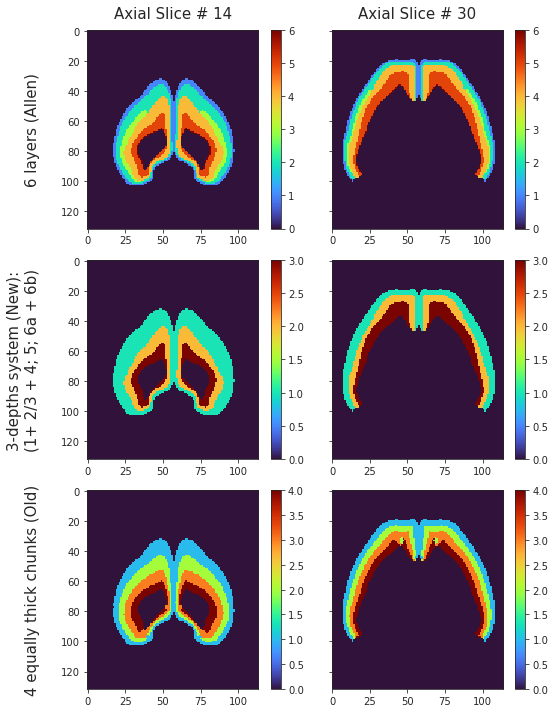

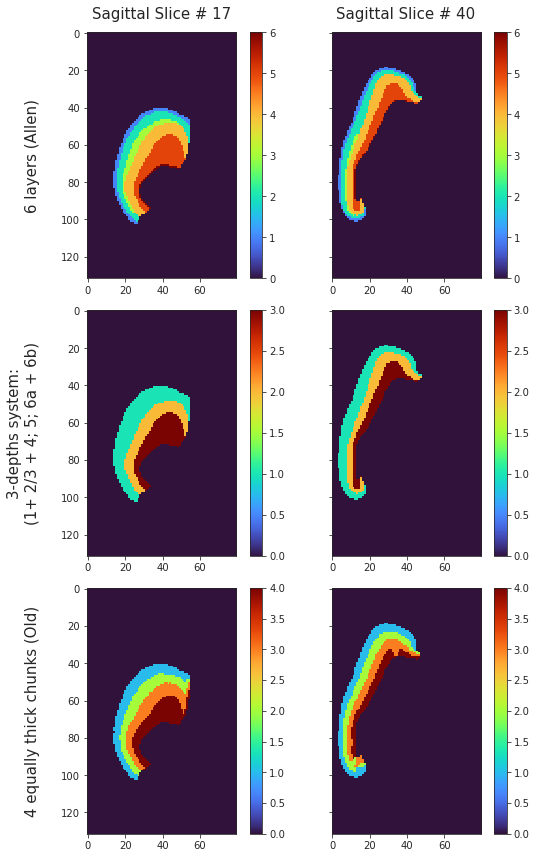

In [6]:
# HIDE CODE


fig, axes = create_figure(3, 2, (13.5, 12), 'row', 'row')

for i, slice_i in enumerate([55, 80]):

    im = axes[0, i].imshow(layer_mask[slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[0, i])
    im = axes[1, i].imshow(layer_mask_3[slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[1, i])
    im = axes[2, i].imshow(layer_mask_4[slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[2, i])
    
    axes[0, i].set_title(f'Coronal Slice # {slice_i}', y=1.03, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('6 layers (Allen)\n', fontsize=15)
        axes[1, i].set_ylabel('3-depths system (New):\n(1+ 2/3 + 4; 5; 6a + 6b)\n', fontsize=15)
        axes[2, i].set_ylabel('4 equally thick chunks (Old)\n', fontsize=15)
plt.show()



fig, axes = create_figure(3, 2, (8, 10), 'row', 'row')

for i, slice_i in enumerate([14, 30]):

    im = axes[0, i].imshow(layer_mask[:, slice_i, :], cmap='turbo')
    plt.colorbar(im, ax=axes[0, i])
    im = axes[1, i].imshow(layer_mask_3[:, slice_i, :], cmap='turbo')
    plt.colorbar(im, ax=axes[1, i])
    im = axes[2, i].imshow(layer_mask_4[:, slice_i, :], cmap='turbo')
    plt.colorbar(im, ax=axes[2, i])
    
    axes[0, i].set_title(f'Axial Slice # {slice_i}', y=1.03, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('6 layers (Allen)\n', fontsize=15)
        axes[1, i].set_ylabel('3-depths system (New):\n(1+ 2/3 + 4; 5; 6a + 6b)\n', fontsize=15)
        axes[2, i].set_ylabel('4 equally thick chunks (Old)\n', fontsize=15)
plt.show()



fig, axes = create_figure(3, 2, (8, 12), 'row', 'row')

for i, slice_i in enumerate([17, 40]):

    im = axes[0, i].imshow(layer_mask[..., slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[0, i])
    im = axes[1, i].imshow(layer_mask_3[..., slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[1, i])
    im = axes[2, i].imshow(layer_mask_4[..., slice_i], cmap='turbo')
    plt.colorbar(im, ax=axes[2, i])
    
    axes[0, i].set_title(f'Sagittal Slice # {slice_i}', y=1.03, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('6 layers (Allen)\n', fontsize=15)
        axes[1, i].set_ylabel('3-depths system:\n(1+ 2/3 + 4; 5; 6a + 6b)\n', fontsize=15)
        axes[2, i].set_ylabel('4 equally thick chunks (Old)\n', fontsize=15)
plt.show()

## Visualize in individual spaces

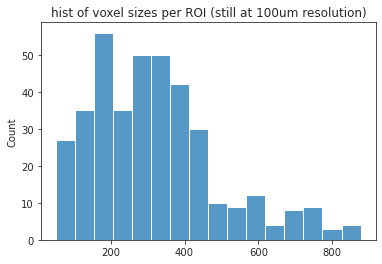

In [7]:
cortex = mice.parcel['cortex']
regions = mice.parcel['regions-cortex']

sizes = collections.Counter(cortex[cortex.nonzero()])
sizes_np = np.array(list(sizes.values()))

sns.histplot(sizes_np)
plt.title('hist of voxel sizes per ROI (still at 100um resolution)')
plt.show()

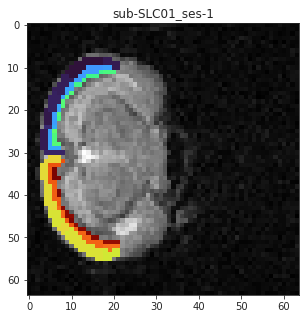

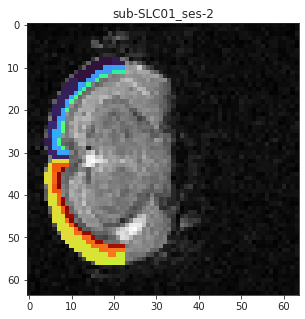

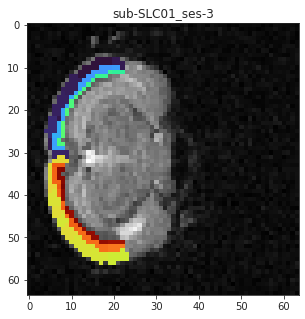

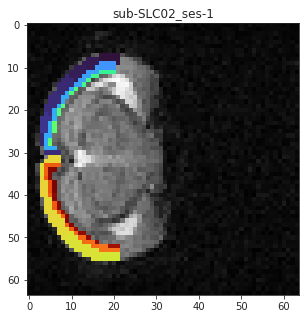

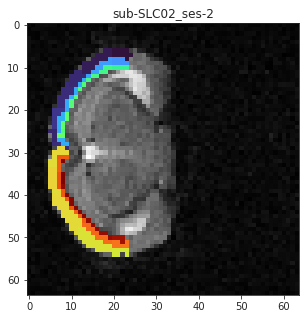

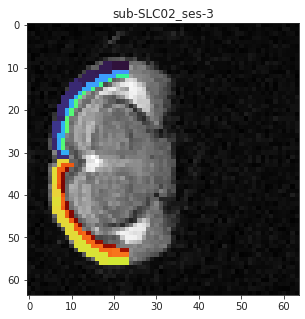

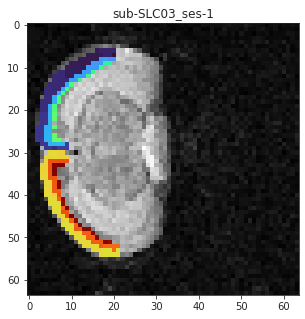

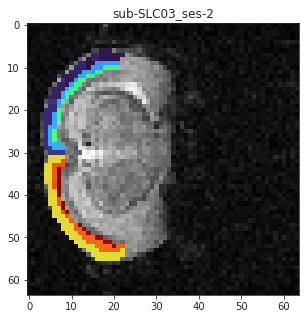

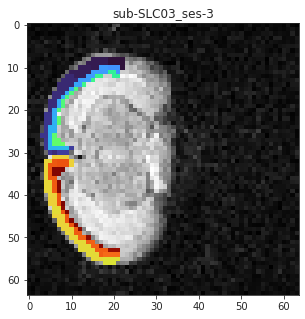

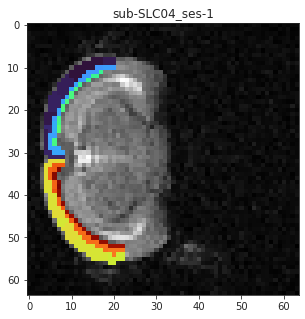

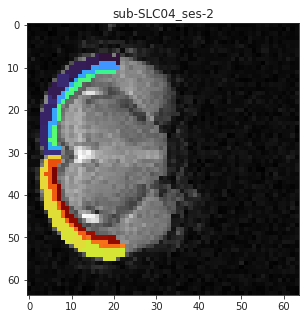

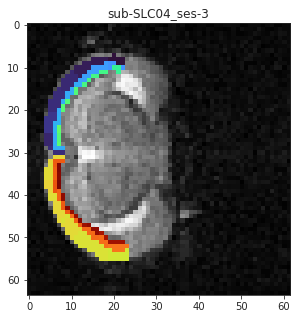

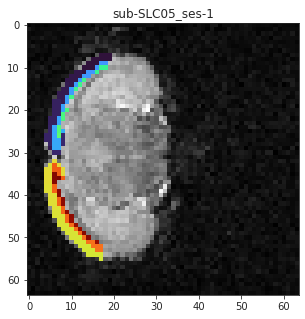

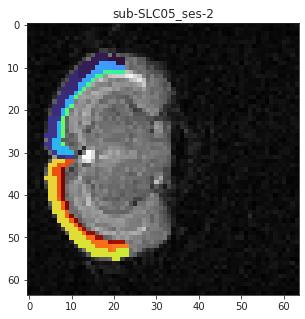

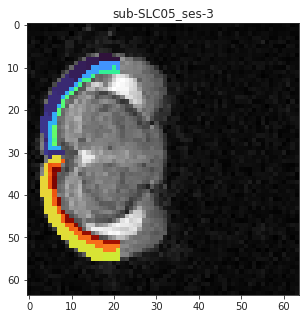

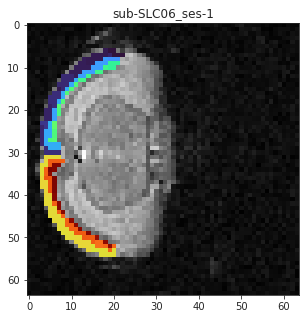

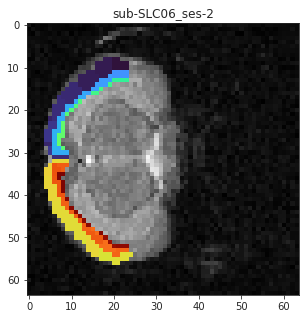

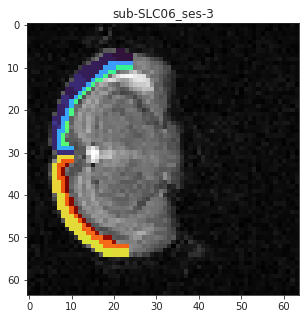

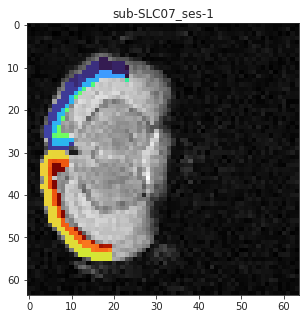

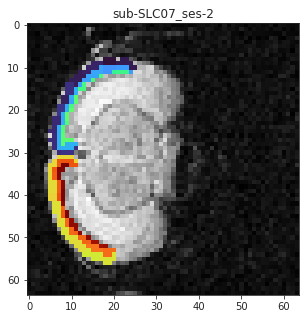

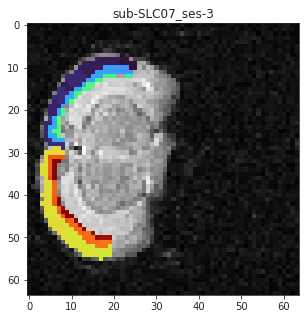

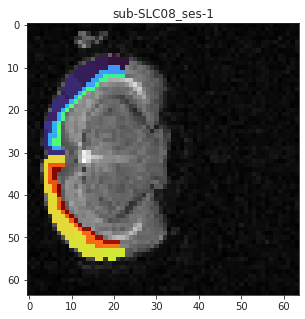

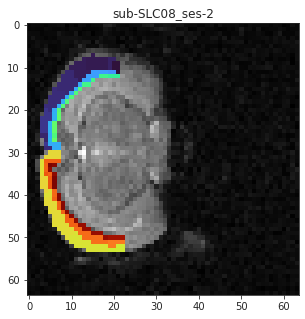

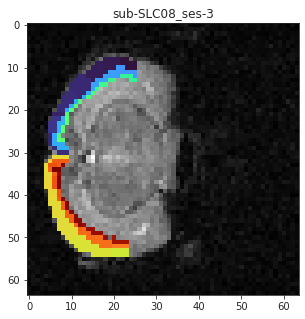

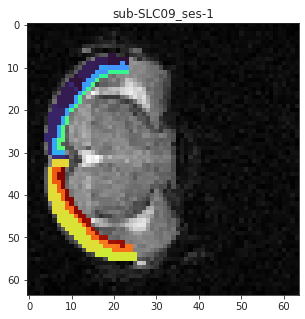

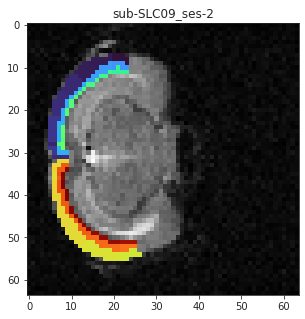

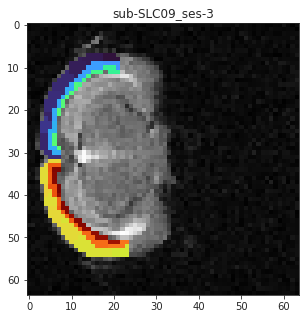

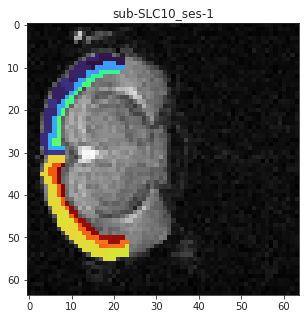

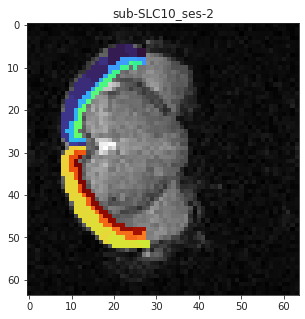

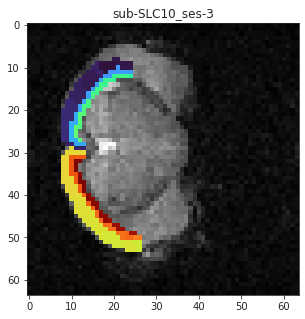

In [8]:
mask_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])

dlist = []
for key, anat in mice.T1w.items():
    file = next(
        f for f in mask_files
        if key in f
    )
    mask = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    x = mask.numpy()
    sizes_indiv = collections.Counter(x[x.nonzero()])
    sizes_indiv = {i: sizes_indiv.get(i, 0) for i in regions}
    
    dlist.append({
        'region': regions,
        'key': [key] * len(regions),
        'vox': sizes_indiv.values(),
    })
    

    plt.figure(figsize=(5, 5))
    data2plt = np.ma.masked_where(~mask.numpy().astype(bool), mask.numpy())
    plt.imshow(anat.load_ants()[..., 35], cmap='Greys_r')
    plt.imshow(data2plt[..., 35], cmap='turbo')
    plt.title(key)
    # plt.show()
    
df_vox = pd.DataFrame(merge_dicts(dlist))

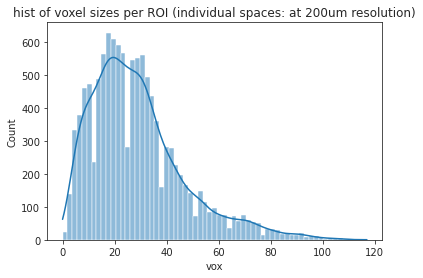

In [9]:
sns.histplot(data=df_vox, x='vox', kde=True)
plt.title('hist of voxel sizes per ROI (individual spaces: at 200um resolution)')
plt.show()

In [15]:
sorted(collections.Counter(df_vox['vox']).most_common())[:10]

[
    (0, 3),
    (1, 21),
    (2, 51),
    (3, 88),
    (4, 155),
    (5, 177),
    (6, 175),
    (7, 205),
    (8, 251),
    (9, 210)
]

## Problem with folding?

## Render

## Transform masks (ignore)

In [2]:
from register.register import Register

mice = Mice((64, 0, 100), load_parcel=True, load_allen=True)
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [11:27<00:00, 22.93s/it]
